<a href="https://colab.research.google.com/github/fzanart/GHDomains/blob/main/Ownership.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
from tqdm import tqdm
import json
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
directory = '/content/drive/MyDrive/GHDomains/Downloaded_repos/'

In [3]:
data = []
to_rescan = []

for filename in tqdm(os.listdir(directory)):
    if not filename.startswith('.'):
        try:
            # Read the file
            aux_reader      = pd.read_json(directory+filename)
            # Correct repo name
            filename   = filename.replace(':', '/')
            filename   = filename.replace('.json', '')
            # Count contributors
            aux_dict        = Counter(aux_reader['Authors:'])
            # Save the total number of contributors
            contributors    = len(aux_dict)
            # Normalize values to calculate ownership
            factor          = 1.0/sum(aux_dict.values())
            norm_dict       = {k: v*factor for k, v in aux_dict.items()}
            ownership       = max(norm_dict, key = lambda k: norm_dict[k])
            # Save ownership
            ownership       = norm_dict[ownership]
            # Save total of major contributors
            major_contrib   = len({k:v for (k,v) in norm_dict.items() if v >= 0.05})
            # Save total of minor contributors
            minor_contrib   = contributors - major_contrib
            # Save totals
            data.extend([(filename, ownership, major_contrib, minor_contrib, contributors)])
        except:
            print('None commits found in: ', filename)
            filename   = filename.replace(':', '/')
            filename   = filename.replace('.json', '')
            to_rescan.extend([filename])

#%%
df = pd.DataFrame(data, columns =['Name', 'Ownership', 'Major contributors', 'Minor contributors', 'Total contributors'])

100%|██████████| 890/890 [00:27<00:00, 32.19it/s]


In [4]:
df

,Name,Ownership,Major contributors,Minor contributors,Total contributors
0,limetext/lime,0.314312,3,56,59
1,pypa/pipenv,0.368817,3,403,406
2,deezer/spleeter,0.360587,4,14,18
3,fchollet/deep-learning-with-python-notebooks,0.666667,3,3,6
4,microsoft/Web-Dev-For-Beginners,0.265613,4,133,137
...,...,...,...,...,...
884,cdnjs/cdnjs,0.427788,3,1628,1631
885,Foundry376/Mailspring,0.457522,3,227,230
886,ElemeFE/node-interview,0.704000,1,29,30
887,mifi/lossless-cut,0.821429,1,77,78


In [5]:
#Get the labels for this list of repos.
new_popular_labels = pd.read_csv('/content/drive/MyDrive/GHDomains/Resources/new_popular_df_predicted.csv', usecols=['Name', 'Predicted_labels'])
df = pd.merge(new_popular_labels, df, on ='Name', how ='inner')
df

,Name,Predicted_labels,Ownership,Major contributors,Minor contributors,Total contributors
0,vuejs/devtools,Web libraries and frameworks,0.468766,3,115,118
1,futurice/android-best-practices,Documentation,0.303644,5,47,52
2,microsoft/Web-Dev-For-Beginners,Documentation,0.265613,4,133,137
3,airbnb/react-sketchapp,Web libraries and frameworks,0.482051,3,64,67
4,eugeneyan/applied-ml,Documentation,0.809524,1,36,37
...,...,...,...,...,...,...
884,graphql/dataloader,Non-web libraries and frameworks,0.556213,2,46,48
885,junyanz/CycleGAN,Non-web libraries and frameworks,0.724490,3,9,12
886,Tencent/wcdb,Application & System software,0.764486,2,18,20
887,halfrost/Halfrost-Field,Non-web libraries and frameworks,0.998051,1,2,3


In [6]:
domains = df['Predicted_labels'].unique()
distributions = []
medians = []
for domain in domains:
    print(domain, ':')
    data1 = df[df['Predicted_labels'] == domain]['Ownership']
    distributions.append(data1)
    medians.append(data1.median())
    for other_domain in domains[domains != domain]:
        print(other_domain)
        data2 = df[df['Predicted_labels'] == other_domain]['Ownership']
        stat, p = mannwhitneyu(data1, data2)
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        # interpret
        alpha = 0.05
        if p > alpha:
            print('Same distribution (fail to reject H0)')
        else:
            print('Different distribution (reject H0)')
    print('=========================================')

Web libraries and frameworks :
Documentation
Statistics=25247.000, p=0.302
Same distribution (fail to reject H0)
Software tools
Statistics=10606.000, p=0.021
Different distribution (reject H0)
Application & System software
Statistics=5529.000, p=0.058
Same distribution (fail to reject H0)
Non-web libraries and frameworks
Statistics=12446.000, p=0.066
Same distribution (fail to reject H0)
Documentation :
Web libraries and frameworks
Statistics=25247.000, p=0.302
Same distribution (fail to reject H0)
Software tools
Statistics=21103.500, p=0.004
Different distribution (reject H0)
Application & System software
Statistics=11039.000, p=0.027
Different distribution (reject H0)
Non-web libraries and frameworks
Statistics=24943.500, p=0.024
Different distribution (reject H0)
Software tools :
Web libraries and frameworks
Statistics=10606.000, p=0.021
Different distribution (reject H0)
Documentation
Statistics=21103.500, p=0.004
Different distribution (reject H0)
Application & System software
Sta

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

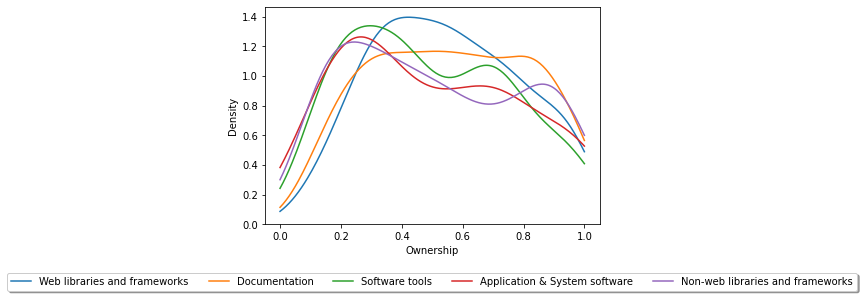

In [7]:
for dist, domain in zip(distributions, domains):
    sns.distplot(dist,hist=False, label=domain, kde_kws={'clip': (0.0, 1.0)})
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=6)
plt.tight_layout()
plt.savefig('myimage.svg', format='svg', dpi=1200)
plt.show()